In [2]:
import scipy as S
import scipy.io
import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pl
import matplotlib.dates as mdates
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.geoaxes as cgeoaxes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from wrf import latlon_coords

from datetime import datetime
from datetime import timedelta
import pytz

from metpy.interpolate import interpolate_1d 
import metpy.calc as mpcalc
from metpy.units import units

# path to modules
import sys
sys.path.append('../modules')

In [3]:
# Set filepath
datdir = '../input_data/wrf_out_post/'
filename = 'wrfout_d03_2017-05-22_00:00:00_surf'

# set output filepath
outdir = '/home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/'
fig_outdir = '/home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/figures/'
dat_outdir = '/home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/data/'


# open wrf Dataset object
filepath = datdir + filename
print('Opened File:', filepath, '\n')

# Open NetCDF Dataset object
da = xr.open_dataset(filepath)

Opened File: ../input_data/wrf_out_post/wrfout_d03_2017-05-22_00:00:00_surf 



/home/sbarc/students/coello/miniconda3/envs/general/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'rh2' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


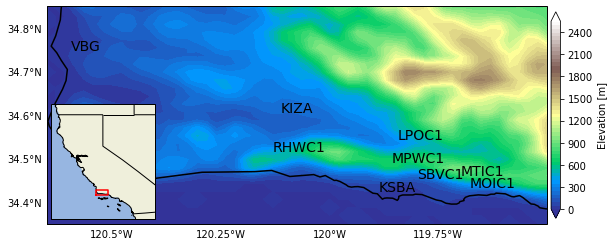

File saved as: /home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/figures/topo_insert_line.png 



In [9]:
def wrf_inset_topo(data, data_units, data_name, data_cols, data_titles, width, height, bounds, stat_labels, lats, lons, \
               station_lons, station_lats, station_names, station_font, boxes, SYM_box_lats, SYM_box_lons, SRM_box_lats, SRM_box_lons, \
               levels_key, levels_in, topo_key, topo, topo_levels, inset_bounds, lat_labels, lon_labels, outdir):

    # set map projection
    mapcrs = ccrs.PlateCarree() # mapcrs - what want in
    datacrs = ccrs.PlateCarree() # datacrs - what comes in

    if (levels_key == False):
        # find min and max of data to make levels for the colorbar that is constant across all subplots
        dmax = np.ceil(np.nanmax(data))
        dmin = np.floor(np.nanmin(data))
        levels = np.arange(dmin, dmax, 100)
    else:
        levels = levels_in
            
    # create figure
    fig = plt.figure(figsize = (width, height))
    gs = plt.GridSpec(1, 1, figure = fig)

    # add plot axes 
    ax = fig.add_subplot(gs[0,0], projection=mapcrs)

    # set plot boundaries
    ax.set_extent(bounds, crs=mapcrs)

    # add map features
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', scale='10m', facecolor='none', name='coastline'),\
                   edgecolor='black', linewidth = 1.5)
    

    # data magntiude (contour filled) 
    cf = ax.contourf(lons, lats, data, transform = datacrs, cmap = data_cols, extend = 'both', levels = levels)
    
    # plot topographic lines if desired
    if (topo_key == True):
        ct = ax.contour(lons, lats, topo, transform = datacrs, colors = 'darkgrey', levels = topo_levels)

    cb = plt.colorbar(cf, orientation = 'vertical', shrink = 0.95, pad = 0.006, label = data_units, alpha = 100)
    
    if (stat_labels == 1):
        # plot stations as points
#         plt.scatter(station_lons, station_lats, color = 'black', s = 10)

        for i in range(len(station_names)):

            plt.annotate(station_names[i], (station_lons[i], station_lats[i]), color = 'black', 
                         textcoords='offset points', xytext=(0,0), ha = 'center', fontsize = station_font)

                
    if (boxes == 1):
        # plot slope box domains
#         plt.scatter(SYM_box_lons, SYM_box_lats, color = 'red', s = 10)
        plt.plot(SYM_box_lons, SYM_box_lats, '--r')
        
    if (boxes == 2):
        # plot slope box domains
        plt.scatter(SYM_box_lons, SYM_box_lats, color = 'red', s = 10)
        plt.plot(SYM_box_lons, SYM_box_lats, '-r')

        plt.scatter(SRM_box_lons, SRM_box_lats, color = 'red', s = 10)
        plt.plot(SRM_box_lons, SRM_box_lats, '-r')
            
    ## Add lat lon labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlines = False
    gl.ylines = False
    gl.xlocator = mticker.FixedLocator(lon_labels)
    gl.ylocator = mticker.FixedLocator(lat_labels)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
            
    # add title for all of subplots
    fig.suptitle(data_titles, fontsize = 12, x = 0.515, y = 0.90)
    

    # add insert map
    axins = fig.add_axes(inset_bounds, projection=ccrs.PlateCarree())
    
    axins.set_extent([-125, -115, 32, 43], crs=mapcrs)

    axins.add_feature(cfeature.NaturalEarthFeature(category='physical', scale='10m', facecolor='none', name='coastline'),\
                   edgecolor='black', linewidth = 1)
    axins.add_feature(cfeature.NaturalEarthFeature(category='cultural', scale='50m', facecolor='none', \
                   name='admin_1_states_provinces_lines'), edgecolor='black', linewidth = 1)
    axins.add_feature(cfeature.LAND)
    axins.add_feature(cfeature.OCEAN)
    axins.add_feature(cfeature.BORDERS)
    
    extent_bounds_x = [bounds[0], bounds[0], bounds[1], bounds[1], bounds[0]]
    extent_bounds_y = [bounds[2], bounds [3], bounds [3], bounds[2], bounds[2]]
    
#     plt.scatter(extent_bounds_x, extent_bounds_y, color = 'red', s = 10)
    plt.plot(extent_bounds_x, extent_bounds_y, '-r')
    
    # Display figure
    # save file name as start datetime end datetime and variable
    plot_name = data_name + '.png'

    plt.savefig(outdir+plot_name,  bbox_inches='tight', dpi = 120)
    plt.show()
    print('File saved as:', outdir+plot_name, '\n')

    
# station locations and names
labels_lats = [34.412, 34.48, 34.65]
labels_lons = [-119.725, -119.745, -119.32]
labels_names = ['SB',  'Santa Ynez Mountains', 'San Rafael \n Mountains']

# these have been modified to fit in the map - they are not exact coordinates
station_lats = [34.455886, 34.516658,  34.461397, 34.491333, 34.4350, 34.544397, 34.42611, 34.60694, 34.75]
station_lons = [ -119.745, -120.07,  -119.649014,  -119.796386, -119.625833,  -119.791286, -119.84361, -120.07556, -120.56] 
stations = ["SBVC1", "RHWC1", "MTIC1", "MPWC1", "MOIC1", "LPOC1", "KSBA", "KIZA", "VBG"]
    
# choose cross section starting and ending lat and lons
cross_lats = [34.9, 34.35]
cross_lons = [-119.643936, -119.643936] # must only include one longitude point

# set topo contour levels
topo_levels = np.arange(0, 2600, 50)

# save terrian variables
topo = da['terr'].values

# save units of terrian
topo_units = 'm'

# save lats and lons
lons = da['lon'].values
lats = da['lat'].values    

## ----------------------------------- plot topography ----------------------------------- ##
wrf_inset_topo(topo, 'Elevation [m]', 'topo_insert_line', 'terrain', '', 12, 4, [-120.65, -119.5, 34.35, 34.85], 1, \
           lats, lons, station_lons, station_lats, stations, 14, \
                  0, cross_lats, cross_lons, None, None, True, topo_levels, False, None, None, \
           [0.19, 0.14, 0.15, 0.4], np.arange(34, 36, 0.1), np.arange(-119.0, -121.6, -0.25), fig_outdir)

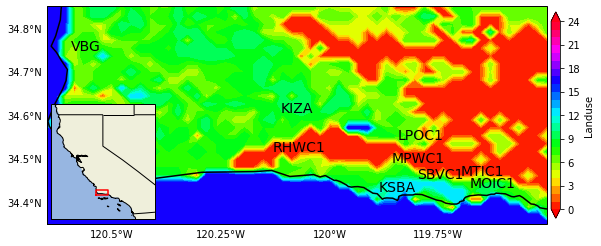

File saved as: /home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/figures/land_use.png 



In [28]:
# set topo contour levels
lu_levels = np.arange(0, 25, 1)   

## ----------------------------------- plot topography ----------------------------------- ##
wrf_inset_topo(da['lu_index'].values, 'Landuse', 'land_use', 'hsv', '', 12, 4, [-120.65, -119.5, 34.35, 34.85], 1, \
           lats, lons, station_lons, station_lats, stations, 14, \
                  0, cross_lats, cross_lons, None, None, True, lu_levels, False, None, None, \
           [0.19, 0.14, 0.15, 0.4], np.arange(34, 36, 0.1), np.arange(-119.0, -121.6, -0.25), fig_outdir)